## Universal Prediction Model for Non-voter-Group

- Idea 1: train model on voter-group, predict on non-voter-group
- Idea 2: use transfer learning (TCA), to apply the feature transformation, then train model on voter-group, predict on non-voter-group




In [1]:
import pandas as pd
import numpy as np
import utils
# import model
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
import matplotlib.pyplot as plt


# data path
file_path = '../data/cumulative_2022_v3_9_domain.csv'

data = pd.read_csv(file_path)

column_to_variable_dict = np.load('../data/column_to_variable_dict.npy', allow_pickle=True).item()
variable_to_column_dict = np.load('../data/variable_to_column_dict.npy', allow_pickle=True).item()

value_label_dict = np.load('../data/value_labels.npy', allow_pickle=True).item()

# check the "Year" column's max and min value
print(data['Year'].max())
print(data['Year'].min())

2020.0
1948.0


In [2]:
target_variable = 'Voted_D_R'

'''Voted_D_R  {0.0: '0. Did not vote; DK/NA if voted; refused to say if', 1.0: '1. Democrat', 2.0: '2. Republican'}'''




data_train = data[(data['Voted_D_R'] == 1) | (data['Voted_D_R'] == 2)]
data_test = data[data['Voted'] == 1]

data_new = pd.concat([data_train, data_test])

print('number of samples who vote Democrat : ', len(data_new[data_new[target_variable] == 1]))
print('number of samples who vote Republican: ', len(data_new[data_new[target_variable] == 2]))
print('number of samples who vote case DK : ', len(data_new[data_new[target_variable] == 0]))
print('number of samples who do not vote : ', len(data_test))
print('number of samples who do vote D or R : ', len(data_train))



number of samples who vote Democrat :  16419
number of samples who vote Republican:  14526
number of samples who vote case DK :  0
number of samples who do not vote :  17790
number of samples who do vote D or R :  30945


In [3]:
missing_value = utils.missing_value_analysis(data_new)

# threshold_list = [0.2, 0.3, 0.4, 0.5]
threshold_list = [0.2, 0.3, 0.4, 0.5]


# must_include_list = ['urbanism']
must_include_list = None


folder_name = '../data/universal_predict/'

used_features, not_used_features, folder_name = utils.feature_filter(data_new, threshold_list,column_to_variable_dict, folder_name, must_include_list)



In [17]:
# use the used features to filter out the data

# set the target variable set and index variable set, these variables will not be used for training

target_variable_list = ['Voted','Registered_voted','Voted_party','Vote_Nonvote_Pres','Voted_D_R']

race_variable_list = ['Race3','Race4','Race7']

religion_variable_list = ['religion']

index_variable_list = ['Year', ]

not_used_features = ['Pre_election_inten_vote']
# not_used_features = []


state_variable_list = ['State']

non_feature_list = target_variable_list +  race_variable_list + religion_variable_list + index_variable_list + not_used_features + state_variable_list

year_threshold = 1982

folder_name = folder_name + '/'+ str(year_threshold)+ '/'

# filter out the samples whose year > year_threshold
data_train = data_train[data_train['Year'] > year_threshold].reset_index(drop=True)
data_test = data_test[data_test['Year'] > year_threshold].reset_index(drop=True)

data_new = pd.concat([data_train, data_test]).reset_index(drop=True)

print(data_train.shape)
print(data_test.shape)
print(data_new.shape)


numerical_feature_list, categorical_feature_list = utils.feature_type_analysis(data_new, used_features, non_feature_list)



(21348, 119)
(9809, 123)
(31157, 123)
number of numerical features:  11
number of categorical features:  48
numerical features list: ['therm_Christians', 'therm_Mislims', 'therm_ChrFundament', 'therm_hispanics', 'therm_RepParty', 'therm_DemParty', 'therm_Whites', 'therm_liberals', 'therm_conservatives', 'therm_Blacks', 'Age']


In [18]:

target_variable = 'Voted_D_R'

Y_target_predict = utils.universal_predict(data_train,data_test, numerical_feature_list, categorical_feature_list, target_variable, value_label_dict, folder_name, group='', group_cat='')



(31157, 60)
average accuracy:  0.9270187062878559
average recall:  0.9350664489219414
average precision:  0.9344787175531423
average f1 score:  0.93473250813851
average roc auc score:  0.9260400980063377
1    5721
0    4088
dtype: int64


In [19]:
Y_target_predict_TCA, Xs_new, Xt_new,X_continuous_categorical_train, X_continuous_categorical_test = utils.universal_predict_TCA(data_train, data_test, numerical_feature_list, categorical_feature_list, target_variable, value_label_dict, folder_name, group='TCA', group_cat='')

(31157, 60)
average accuracy:  0.9271123940745959
average recall:  0.9363216298619376
average precision:  0.9335421481936741
average f1 score:  0.9348932735062361
average roc auc score:  0.9259712278083277
1    6063
0    3746
dtype: int64


In [20]:
# identify the samples whose prediction is different from the Y_target_predict and Y_target_predict_TCA
data_test['Y_target_predict'] = Y_target_predict
data_test['Y_target_predict_TCA'] = Y_target_predict_TCA

data_test['Y_target_predict_diff'] = data_test['Y_target_predict'] - data_test['Y_target_predict_TCA']

data_test['Y_target_predict_diff'] = data_test['Y_target_predict_diff'].apply(lambda x: 1 if x != 0 else 0)

differ_index = data_test[data_test['Y_target_predict_diff'] == 1].index

In [23]:
# apply PCA on both Xs_new and Xt_new, and plot the first two components

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

Xs_new_pca = pca.fit_transform(Xs_new)

Xt_new_pca = pca.transform(Xt_new)

Xs_raw_pca = pca.fit_transform(X_continuous_categorical_train)

Xt_raw_pca = pca.transform(X_continuous_categorical_test)

index_vote_D = data_train[data_train['Voted_D_R'] == 1].index

index_vote_R = data_train[data_train['Voted_D_R'] == 2].index





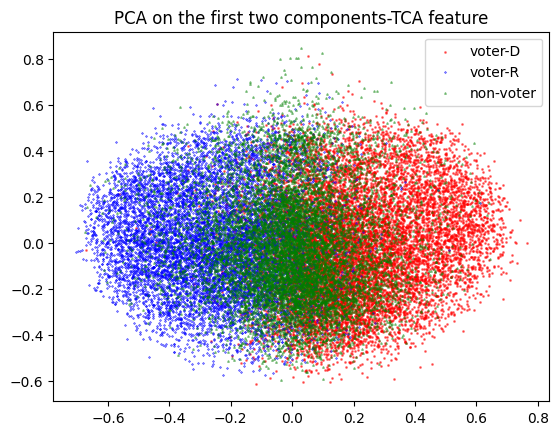

In [31]:
plt.scatter(Xs_new_pca[index_vote_D,0], Xs_new_pca[index_vote_D,1], c='r', label='voter-D', marker='o', alpha=0.5, s=1)
plt.scatter(Xs_new_pca[index_vote_R,0], Xs_new_pca[index_vote_R,1], c='b', label='voter-R', marker='x', alpha=0.5, s=1)

plt.scatter(Xt_new_pca[:,0], Xt_new_pca[:,1], c='g', label='non-voter', marker='^', alpha=0.5, s=1)

plt.title('PCA on the first two components-TCA feature')
plt.legend()

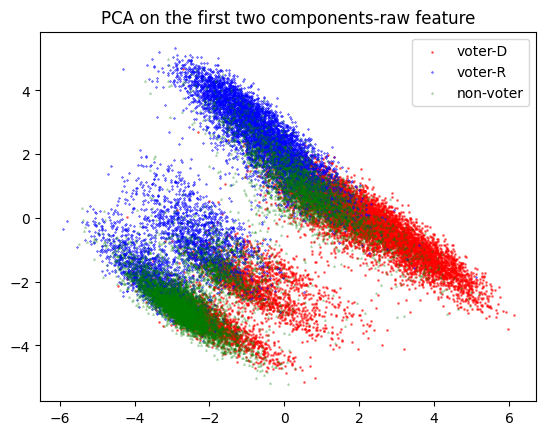

In [34]:
plt.scatter(Xs_raw_pca[index_vote_D,0], Xs_raw_pca[index_vote_D,1], c='r', label='voter-D', marker='o', alpha=0.5, s=1)
plt.scatter(Xs_raw_pca[index_vote_R,0], Xs_raw_pca[index_vote_R,1], c='b', label='voter-R', marker='x', alpha=0.5, s=1)

plt.scatter(Xt_raw_pca[:,0], Xt_raw_pca[:,1], c='g', label='non-voter', marker='^', alpha=0.3, s=1)
plt.title('PCA on the first two components-raw feature')
plt.legend()


In [ ]:


# data_source = data_train
# data_target = data_test

# N1 = len(data_source)
# N2 = len(data_target)

# data_group = pd.concat([data_source, data_target]).reset_index(drop=True)

# X_categorical_transformed, X_continuous_transformed, Y_target, enc_categorical_feature_list = utils.feature_process(data_group, numerical_feature_list, categorical_feature_list, target_variable,value_label_dict)

# X_continuous_categorical = np.concatenate((X_continuous_transformed, X_categorical_transformed), axis=1)

# # only use the source data to train the model
# Y_target_train = Y_target[:N1]

# X_continuous_categorical_train = X_continuous_categorical[:N1]

# X_continuous_categorical_test = X_continuous_categorical[N1:]


# print(X_continuous_categorical_train.shape)
# print(X_continuous_categorical_test.shape)



(31157, 60)
(21348, 233)
(9809, 233)
